## Garbage Classification Models: Evaluation


## Imports and Configuration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torchvision.models.efficientnet import EfficientNet_B0_Weights
import os
import re
import logging
import sys
import numpy as np
from collections import Counter
from transformers import DistilBertModel, DistilBertTokenizer
import wandb
from sklearn.model_selection import StratifiedKFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time
import torch.nn.functional as F
import spacy
from nltk.corpus import stopwords
from scipy.stats import mode
from PIL import Image

# ========================================= GLOBAL CONFIGURATION ================================================
# Data Directories
DATA_DIR = r"C:\NN Data\garbage_data\kfold_garbage_data"
CLASSES = ["Black", "Blue", "Green", "TTR"]

# ========================================= Data Settings =========================================
IMAGE_SIZE = (224, 224)  # Input image size for EfficientNetV2-S
NUM_CLASSES = 4  # Number of output classes for classification
MAX_LEN = 40  # Maximum token length for DistilBERT tokenizer
TEST_SIZE = 0.2  # Test dataset size split
K_FOLDS = 5  # Number of folds for stratified k-fold cross-validation

# ========================================= Training Hyperparameters =========================================
BATCH_SIZE = 64  # Number of samples per batch
GRAD_ACCUM_STEPS = 4
EPOCHS = 50  # Maximum number of training epochs
DROPOUT_IMAGE = 0.2 # Reduce from 0.3
DROPOUT_TEXT = 0.1 # Reduce from 0.2
DROPOUT_FUSION = 0.2 
DROPOUT_CLASSIFIER = 0.1
PATIENCE = 10  # Number of epochs to wait before early stopping
CONVERGENCE_THRESHOLD = 0.001  # Minimum improvement in validation loss to continue training

# ========================================= Optimization Settings =========================================
OPTIMIZER = "AdamW"
LR_SCHEDULING_FACTOR = 0.3
LEARNING_RATE_UNFREEZE_IMAGE = 1e-5
LEARNING_RATE_UNFREEZE_TEXT = 1e-5
LEARNING_RATE_FUSION = 1e-3
LEARNING_RATE_CLASSIFIER = 5e-3
LEARNING_RATE_IMAGE = 0.001 # # EfficientNetB0
LEARNING_RATE_TEXT = 0.00002 # DistilBERT Uncased
WEIGHT_DECAY_TEXT = 1e-3  # Reduce from 1e-2
WEIGHT_DECAY_IMAGE = 1e-4  # Reduce from 1e-3
WEIGHT_DECAY_FUSION = 4e-4 
WEIGHT_DECAY_CLASSIFIER = 1e-3  # Reduce from 1e-4
LABEL_SMOOTHING_PREDICTION = 0.05 # Reduce from 0.1

# ========================================= System Settings =========================================
NUM_WORKERS = 4  # Dataloader parallelization

# Normalization Stats
NORMALIZATION_STATS = EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

## Helper Function

In [2]:
# Load SpaCy for lemmatization
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    """Standardize text, remove stopwords, and apply lemmatization."""
    # 1. Standardize text (lowercasing & trimming spaces)
    text = text.strip().lower()

    # 2. Remove stopwords
    text_tokens = text.split()
    text = " ".join([word for word in text_tokens if word not in stop_words])

    # 3. Lemmatization
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])

    return text

def read_text_files_with_labels_and_image_paths(path):
    """Extract text from file names, apply preprocessing, and return labels with image paths."""
    texts, labels, image_paths = [], [], []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = sorted(os.listdir(class_path))  # Sort to ensure order consistency
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    # Extract filename without extension
                    file_name_no_ext, _ = os.path.splitext(file_name)

                    # Replace underscores with spaces
                    text = file_name_no_ext.replace("_", " ")

                    # Remove numbers
                    text_without_digits = re.sub(r"\d+", "", text)

                    # Apply preprocessing
                    preprocessed_text = preprocess_text(text_without_digits)

                    texts.append(preprocessed_text)
                    labels.append(label_map[class_name])
                    image_paths.append(file_path)

    return np.array(texts), np.array(labels), np.array(image_paths)

## Load Data

In [3]:
logging.info("[INFO] Extracting text, labels, and image paths...")
texts, labels, image_paths= read_text_files_with_labels_and_image_paths(DATA_DIR)

## Dataset Classes

In [4]:
class CustomTextDataset(Dataset):
    """Dataset class for text data."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
# Custom dataset class for images
class ImageDataset(Dataset):
    """Dataset class for image data."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)



class MultimodalDataset(Dataset):
    """Dataset class for multimodal data (image + text)."""
    def __init__(self, image_dataset, text_dataset):
        self.image_dataset = image_dataset
        self.text_dataset = text_dataset

    def __len__(self):
        return min(len(self.image_dataset), len(self.text_dataset))

    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        text_data = self.text_dataset[idx]
        return {
            "image": image,
            "input_ids": text_data["input_ids"],
            "attention_mask": text_data["attention_mask"],
            "label": label
        }

## Model Definitions

### Hybrid Gated-Attention

In [5]:
# Attention Gated
# ======================== Gated Fusion ========================
class GatedFusionGatedAttention(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.gate = nn.Linear(2 * feature_dim, feature_dim)  # Learnable gate
        self.sigmoid = nn.Sigmoid()  # Activation

    def forward(self, text_feat, image_feat):
        combined_feat = torch.cat((text_feat, image_feat), dim=1)
        gate_value = self.sigmoid(self.gate(combined_feat))  # Value between 0-1
        fused_feat = (gate_value * text_feat) + ((1 - gate_value) * image_feat)  # Weighted fusion
        return fused_feat

# ======================== Attention Fusion ========================
class AttentionFusionGatedAttention(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.Wq = nn.Linear(feature_dim, feature_dim)  # Query
        self.Wk = nn.Linear(feature_dim, feature_dim)  # Key
        self.Wv = nn.Linear(feature_dim, feature_dim)  # Value
        self.softmax = nn.Softmax(dim=1)

    def forward(self, fused_feat):
        q = self.Wq(fused_feat)
        k = self.Wk(fused_feat)
        v = self.Wv(fused_feat)
        
        attention_scores = self.softmax(torch.bmm(q.unsqueeze(1), k.unsqueeze(2)).squeeze(2))
        refined_feat = attention_scores * v  # Weighted fusion
        return refined_feat + fused_feat  # Residual connection

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifierGatedAttention(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Gated Fusion -----------
        self.gated_fusion = GatedFusionGatedAttention(feature_dim=512)

        # ----------- Attention Fusion -----------
        self.attention_fusion = AttentionFusionGatedAttention(feature_dim=512)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # GELU activation
        )

        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        gated_feat = self.gated_fusion(text_features, image_features)
        refined_feat = self.attention_fusion(gated_feat)
        fused_features = self.fusion_fc(refined_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


### Attention Only

In [6]:
# Attention Only

class AttentionFusionAttentionOnly(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        # For cross-modal attention
        self.Wq_text = nn.Linear(feature_dim, feature_dim)  # Query from text
        self.Wk_image = nn.Linear(feature_dim, feature_dim)  # Key from image
        self.Wv_image = nn.Linear(feature_dim, feature_dim)  # Value from image
        
        self.Wq_image = nn.Linear(feature_dim, feature_dim)  # Query from image
        self.Wk_text = nn.Linear(feature_dim, feature_dim)  # Key from text
        self.Wv_text = nn.Linear(feature_dim, feature_dim)  # Value from text
        
        self.softmax = nn.Softmax(dim=1)
        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, text_feat, image_feat):
        # Text-to-image attention
        q_text = self.Wq_text(text_feat).unsqueeze(1)  # [batch, 1, dim]
        k_image = self.Wk_image(image_feat).unsqueeze(2)  # [batch, dim, 1]
        v_image = self.Wv_image(image_feat)  # [batch, dim]
        
        # Image-to-text attention
        q_image = self.Wq_image(image_feat).unsqueeze(1)  # [batch, 1, dim]
        k_text = self.Wk_text(text_feat).unsqueeze(2)  # [batch, dim, 1]
        v_text = self.Wv_text(text_feat)  # [batch, dim]
        
        # Compute attention scores
        text_attention = self.softmax(torch.bmm(q_text, k_image).squeeze(2))  # [batch, 1]
        image_attention = self.softmax(torch.bmm(q_image, k_text).squeeze(2))  # [batch, 1]
        
        # Apply attention
        text_out = text_attention * v_image + text_feat  # [batch, dim]
        image_out = image_attention * v_text + image_feat  # [batch, dim]
        
        # Combine and normalize
        fused_feat = self.layer_norm(text_out + image_out)
        return fused_feat

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifierAttentionOnly(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Attention Fusion -----------
        self.attention_fusion = AttentionFusionAttentionOnly(feature_dim=512)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # GELU activation
        )

        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        attention_feat = self.attention_fusion(text_features, image_features)
        fused_features = self.fusion_fc(attention_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


### Gated Only

In [7]:
# Gated Only

# ======================== Gated Fusion ========================
class GatedFusionGatedOnly(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.gate = nn.Linear(2 * feature_dim, feature_dim)  # Learnable gate
        self.sigmoid = nn.Sigmoid()  # Activation

    def forward(self, text_feat, image_feat):
        combined_feat = torch.cat((text_feat, image_feat), dim=1)
        gate_value = self.sigmoid(self.gate(combined_feat))  # Value between 0-1
        fused_feat = (gate_value * text_feat) + ((1 - gate_value) * image_feat)  # Weighted fusion
        return fused_feat

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifierGatedOnly(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Gated Fusion -----------
        self.gated_fusion = GatedFusionGatedOnly(feature_dim=512)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use GELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # GELU activation
        )

        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        gated_feat = self.gated_fusion(text_features, image_features)
        fused_features = self.fusion_fc(gated_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


### Simple Concatenation

In [8]:
# Enetb0_224

class MultimodalClassifierEnet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # EfficientNet-B0 for image feature extraction
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Freeze all layers of EfficientNet-B0 initially
        for param in self.image_model.parameters():
            param.requires_grad = False

        # Unfreeze the last 3 layers of EfficientNet-B0
        for param in self.image_model.features[-3:].parameters():
            param.requires_grad = True

        # Remove the classifier layer of EfficientNet-B0 to use a custom prediction layer
        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()

        # Project image features to 256 dimensions
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.BatchNorm1d(256),  # Add batch normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
            )  # Dropout for image features

        # DistilBERT for text feature extraction
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers of DistilBERT initially
        for param in self.text_model.parameters():
            param.requires_grad = False

        # Unfreeze the last 1 layers of DistilBERT
        for param in self.text_model.transformer.layer[-2:].parameters():
            param.requires_grad = True

        # Project text features to 256 dimensions
        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 256),
            nn.BatchNorm1d(256),  # Add batch normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)  # Dropout for text features
        )

        # Normalization layers
        self.text_norms = nn.LayerNorm(256)
        self.image_norm = nn.LayerNorm(256)

        # Feature fusion layer (concatenation of text and image features)
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Concatenated features have 512 dimensions
            nn.BatchNorm1d(512),
            nn.ReLU(),  # Add ReLU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # ReLU activation
        )

        # Dropout layer for the final classification layer
        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        # Extract text features
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])  # Use the [CLS] token
        text_features = self.text_norms(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        text_features = F.normalize(text_features, p=2, dim=1)
        image_features = F.normalize(image_features, p=2, dim=1)
        combined_features = torch.cat((text_features, image_features), dim=1)
        combined_features = self.fusion_fc(combined_features)
        output = self.classifier(self.dropout(combined_features))

        return output

### Transformer Fusion

In [9]:
# Transformer Fusion

class MultimodalClassifierTransformerFusion(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with Transformer-based fusion."""
    def __init__(self, num_classes):
        super().__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-3:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)  # Use global dropout for image features
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-2:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)  # Use global dropout for text features
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(512)
        self.image_norm = nn.LayerNorm(512)

        # ----------- Transformer Fusion -----------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,  # Match the feature dimension
            nhead=8,       # Number of attention heads
            dim_feedforward=4096,  # Feedforward dimension
            dropout=0.1,   # Dropout rate
            activation="gelu",  # Use GELU activation
            norm_first=True  # Enable layer normalization
        )
        self.transformer_fusion = nn.TransformerEncoder(
            encoder_layer,
            num_layers=4  # Number of encoder layers
        )

        # ----------- Fusion Layers -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(512, 512),  # Increase dimension
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),            # Use RELU activation

            nn.Linear(512, 256),  # Intermediate layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),            # RELU activation
        )

        # ----------- Classifier Layer -----------
        self.dropout = nn.Dropout(DROPOUT_CLASSIFIER)
        self.classifier = nn.Linear(256, num_classes)  # Final output layer


    def forward(self, input_ids, attention_mask, image_inputs):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)
        combined = torch.cat((image_features.unsqueeze(1), text_features.unsqueeze(1)), dim=1)
        fused_features = self.transformer_fusion(combined)
        fused_features = fused_features.mean(dim=1)
        fused_features = self.fusion_fc(fused_features)
        output = self.classifier(self.dropout(fused_features))
        
        return output

### Data setup

In [10]:
# Load dataset
texts, labels, image_paths = read_text_files_with_labels_and_image_paths(DATA_DIR)

# Log first and last 4 samples
logging.info("First 4 samples of dataset:\n")
logging.info(f"Texts: {texts[:4]}")
logging.info(f"Labels: {labels[:4]}")
logging.info(f"Image Paths: {image_paths[:4]}")

logging.info("\nLast 4 samples of dataset:\n")
logging.info(f"Texts: {texts[-4:]}")
logging.info(f"Labels: {labels[-4:]}")
logging.info(f"Image Paths: {image_paths[-4:]}")

### Split into test set and development set

In [11]:
# Split into a test set and development set
train_texts, test_texts, train_labels, test_labels, train_image_paths, test_image_paths = train_test_split(
    texts, labels, image_paths, test_size=TEST_SIZE, stratify=labels, random_state=42
)

# Log first 4 samples of test set
logging.info("First 4 samples of test set:\n")
logging.info(f"Texts: {test_texts[:4]}")
logging.info(f"Labels: {test_labels[:4]}")
logging.info(f"Image Paths: {test_image_paths[:4]}")

logging.info("\nLast 4 samples of test set:\n")
logging.info(f"Texts: {test_texts[-4:]}")
logging.info(f"Labels: {test_labels[-4:]}")
logging.info(f"Image Paths: {test_image_paths[-4:]}")

### Define Transformations

In [12]:
# Define transformations
transform = {
    "train": transforms.Compose([
        transforms.Resize(IMAGE_SIZE), 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Apply correct normalization
    ]),
    "val": transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Only resize + normalize
    ]),
    "test": transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Only resize + normalize
    ])
}

# Tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def get_adaptive_train_transform(epoch, max_epoch=20):
    """Dynamically adjust augmentation intensity based on epoch number."""
    brightness_factor = 0.4 if epoch < max_epoch * 0.5 else 0.2
    rotation_angle = 30 if epoch < max_epoch * 0.3 else 15  # Reduce rotation intensity over time
    crop_scale = (0.6, 1.0) if epoch < max_epoch * 0.3 else (0.8, 1.0)  # More aggressive cropping early on

    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=brightness_factor, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomRotation(rotation_angle),
        transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),  # Higher variability in early training
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=crop_scale),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)
    ])

### DataLoader for test set

Create the dataloader for the test set and set aside for model evaluation.

In [13]:
# Create test dataset
test_image_dataset = ImageDataset(test_image_paths, test_labels, transform["test"])
test_text_dataset = CustomTextDataset(test_texts, test_labels, tokenizer, max_len=MAX_LEN)  # Ensure tokenizer is defined
test_multimodal_dataset = MultimodalDataset(test_image_dataset, test_text_dataset)

# DataLoader for test set
test_loader = DataLoader(test_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=False)

Take a peek at a batch in the test set to verify that data has been correctly organized.

In [14]:
# Get one batch
for batch in test_loader:
    images = batch["image"]  # Image tensor
    input_ids = batch["input_ids"]  # Tokenized text tensor
    attention_mask = batch["attention_mask"]  # Attention mask
    labels = batch["label"]  # Labels tensor

    # Log shapes of tensors
    logging.info("[INFO] One Batch Sample Inspection:")
    logging.info(f"   Images Shape: {images.shape}")
    logging.info(f"   Input IDs Shape: {input_ids.shape}")
    logging.info(f"   Attention Mask Shape: {attention_mask.shape}")
    logging.info(f"   Labels Shape: {labels.shape}")

    # Log first sample details
    logging.info("\n[INFO] First Sample:")
    logging.info(f"   Image Tensor: {images[0]}")
    logging.info(f"   Input IDs: {input_ids[0]}")
    logging.info(f"   Attention Mask: {attention_mask[0]}")
    logging.info(f"   Label: {labels[0]}")

    break  # Stop after inspecting one batch


# Model Evaluation

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, f1_score
)
import numpy as np
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn

def test_model_with_metrics(model, dataloader, device, class_labels, 
                           show_confusion_matrix=True, show_roc_curve=True, 
                           show_pr_curve=True, model_path=None):
    """
    Evaluates the model and computes confusion matrix, precision, recall, F1-score, ROC curve, and PR curve.
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader containing the test data
        device: Device to use for evaluation (e.g., 'cuda' or 'cpu')
        class_labels: List of class names
        show_confusion_matrix: Whether to display the confusion matrix plot (default: True)
        show_roc_curve: Whether to display the ROC curve plot (default: True)
        show_pr_curve: Whether to display the Precision-Recall curve plot (default: True)
        
    Returns:
        Tuple containing (accuracy, classification_report, roc_auc, pr_auc, f1_scores)
        where f1_scores is a dictionary with 'macro', 'micro', 'weighted', and 'per_class' F1 scores
    """
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            # Move data to GPU
            images, input_ids, attention_mask, labels = (
                batch["image"].to(device),
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )

            # Forward pass
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions & probabilities
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class

            # Store results
            all_probs.extend(probs.cpu().numpy())  # Store probabilities for ROC
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store ground truth labels

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Convert labels to one-hot encoding
    all_labels_bin = label_binarize(all_labels, classes=np.arange(len(class_labels)))

    # Compute Accuracy
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=class_labels, output_dict=True)
    
    # Calculate F1 scores
    f1_scores = {
        'macro': f1_score(all_labels, all_preds, average='macro'),
        'micro': f1_score(all_labels, all_preds, average='micro'),
        'weighted': f1_score(all_labels, all_preds, average='weighted'),
        'per_class': f1_score(all_labels, all_preds, average=None)
    }

    print(f"\nTest Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_labels))
    print("\nF1 Scores:")
    print(f"Macro F1: {f1_scores['macro']:.4f}")
    print(f"Micro F1: {f1_scores['micro']:.4f}")
    print(f"Weighted F1: {f1_scores['weighted']:.4f}")
    print("Per-class F1:", ", ".join([f"{class_labels[i]}: {score:.4f}" for i, score in enumerate(f1_scores['per_class'])]))

    # --- Plot and Save Confusion Matrix ---
    if show_confusion_matrix or model_path:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        
        # Save the confusion matrix if model_path is provided
        if model_path:
            import os
            # Extract base filename and remove .pth extension
            base_name = os.path.basename(model_path).replace('.pth', '')
            cm_filename = f"cm_{base_name}.png"
            
            # Create directory if it doesn't exist
            os.makedirs("confusion_matrices", exist_ok=True)
            save_path = os.path.join("confusion_matrices", cm_filename)
            
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Saved confusion matrix to {save_path}")
        
        if show_confusion_matrix:
            plt.show()
        else:
            plt.close()

    # --- ROC Curve ---
    if show_roc_curve or model_path:
        plt.figure(figsize=(8, 6))
        fpr, tpr, roc_auc = {}, {}, {}
        
        for i in range(len(class_labels)):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

        fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"Micro Avg (AUC = {roc_auc['micro']:.2f})")

        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        
        if model_path:
            plt.savefig(f"plots/roc_{base_name}.png", bbox_inches='tight', dpi=300)
        
        if show_roc_curve:
            plt.show()
        else:
            plt.close()

    # --- PR Curve ---
    if show_pr_curve or model_path:
        plt.figure(figsize=(8, 6))
        pr_auc = {}
        
        for i in range(len(class_labels)):
            precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
            pr_auc[i] = average_precision_score(all_labels_bin[:, i], all_probs[:, i])
            plt.plot(recall, precision, label=f"{class_labels[i]} (AP = {pr_auc[i]:.2f})")

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        
        if model_path:
            plt.savefig(f"plots/pr_{base_name}.png", bbox_inches='tight', dpi=300)
        
        if show_pr_curve:
            plt.show()
        else:
            plt.close()

    return accuracy, class_report, roc_auc, pr_auc, f1_scores


Evaluating Attention Only model across all folds

Fold 1:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3589, Test Accuracy: 0.8690

Classification Report:
               precision    recall  f1-score   support

       Black       0.78      0.79      0.78       548
        Blue       0.87      0.91      0.89      1122
       Green       0.91      0.90      0.91       534
         TTR       0.92      0.84      0.88       482

    accuracy                           0.87      2686
   macro avg       0.87      0.86      0.86      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8639
Micro F1: 0.8690
Weighted F1: 0.8690
Per-class F1: Black: 0.7840, Blue: 0.8900, Green: 0.9065, TTR: 0.8751
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_only_fold_1.png


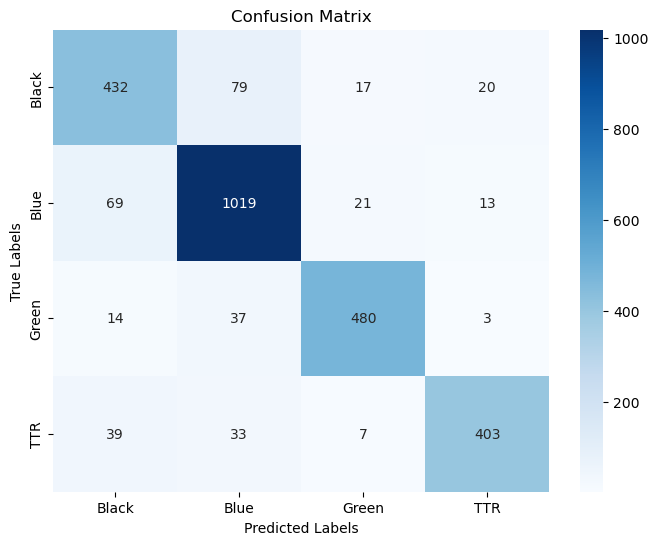


Fold 2:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3680, Test Accuracy: 0.8641

Classification Report:
               precision    recall  f1-score   support

       Black       0.78      0.77      0.77       548
        Blue       0.88      0.88      0.88      1122
       Green       0.91      0.91      0.91       534
         TTR       0.87      0.89      0.88       482

    accuracy                           0.86      2686
   macro avg       0.86      0.86      0.86      2686
weighted avg       0.86      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8604
Micro F1: 0.8641
Weighted F1: 0.8640
Per-class F1: Black: 0.7732, Blue: 0.8805, Green: 0.9098, TTR: 0.8782
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_only_fold_2.png


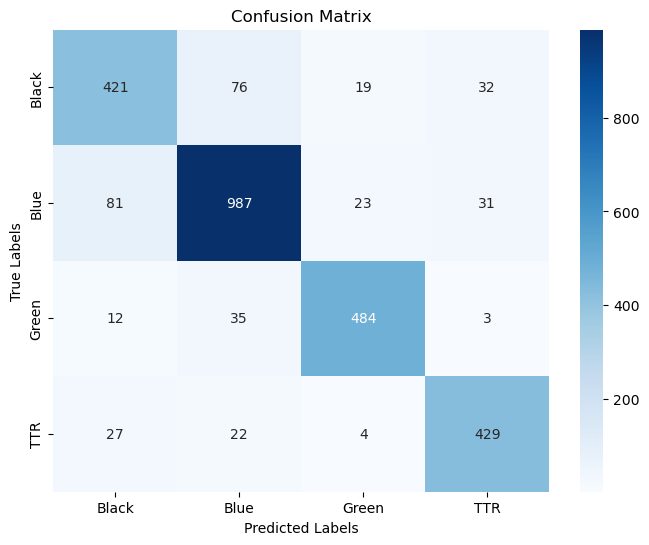


Fold 3:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3721, Test Accuracy: 0.8786

Classification Report:
               precision    recall  f1-score   support

       Black       0.82      0.78      0.80       548
        Blue       0.88      0.91      0.89      1122
       Green       0.93      0.91      0.92       534
         TTR       0.88      0.88      0.88       482

    accuracy                           0.88      2686
   macro avg       0.88      0.87      0.87      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8746
Micro F1: 0.8786
Weighted F1: 0.8783
Per-class F1: Black: 0.8030, Blue: 0.8939, Green: 0.9187, TTR: 0.8827
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_only_fold_3.png


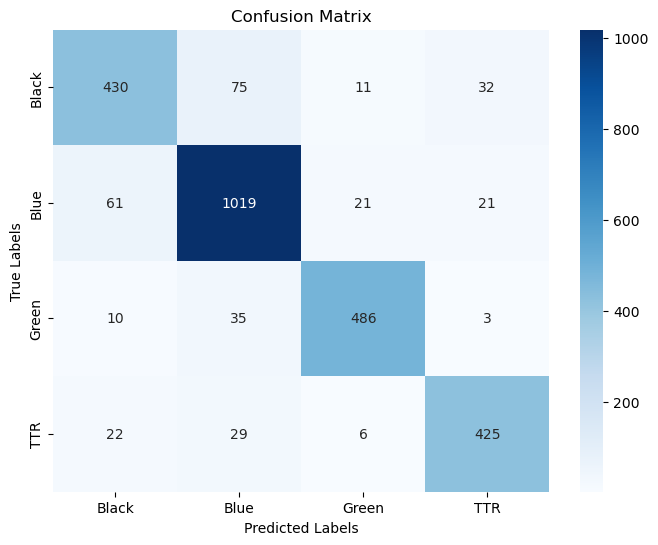


Fold 4:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3681, Test Accuracy: 0.8667

Classification Report:
               precision    recall  f1-score   support

       Black       0.77      0.79      0.78       548
        Blue       0.88      0.88      0.88      1122
       Green       0.90      0.91      0.91       534
         TTR       0.91      0.88      0.89       482

    accuracy                           0.87      2686
   macro avg       0.86      0.86      0.86      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8648
Micro F1: 0.8667
Weighted F1: 0.8671
Per-class F1: Black: 0.7792, Blue: 0.8796, Green: 0.9077, TTR: 0.8926
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_only_fold_4.png


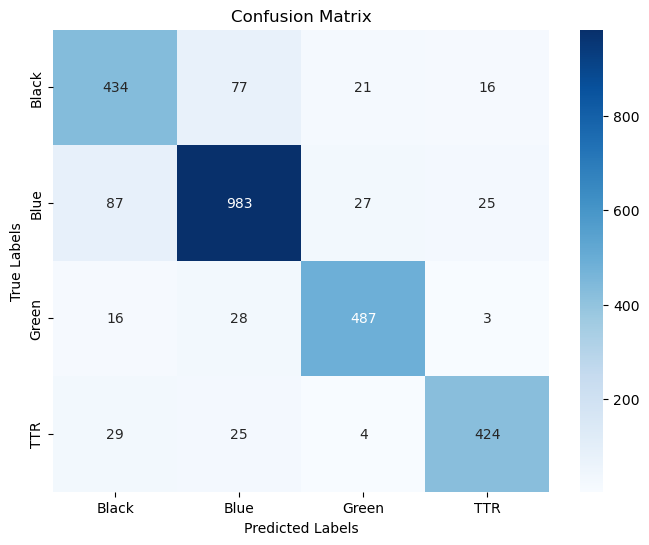


Fold 5:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3508, Test Accuracy: 0.8827

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.81      0.80       548
        Blue       0.88      0.90      0.89      1122
       Green       0.93      0.92      0.93       534
         TTR       0.93      0.88      0.90       482

    accuracy                           0.88      2686
   macro avg       0.89      0.88      0.88      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8813
Micro F1: 0.8827
Weighted F1: 0.8829
Per-class F1: Black: 0.8040, Blue: 0.8924, Green: 0.9258, TTR: 0.9029
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_only_fold_5.png


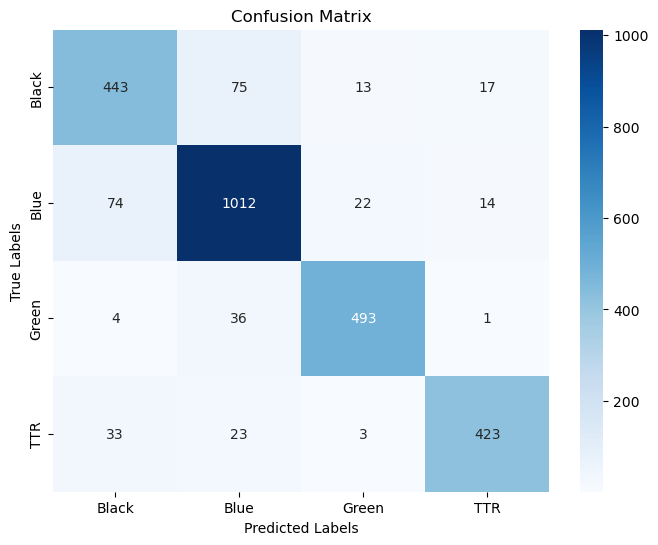


Saved individual fold results to model_results/Attention_Only_fold_results.csv

Evaluating Gated Only model across all folds

Fold 1:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3537, Test Accuracy: 0.8686

Classification Report:
               precision    recall  f1-score   support

       Black       0.78      0.79      0.79       548
        Blue       0.88      0.89      0.88      1122
       Green       0.93      0.90      0.91       534
         TTR       0.88      0.87      0.88       482

    accuracy                           0.87      2686
   macro avg       0.87      0.86      0.87      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8652
Micro F1: 0.8686
Weighted F1: 0.8688
Per-class F1: Black: 0.7858, Blue: 0.8846, Green: 0.9141, TTR: 0.8762
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_gated_only_fold_1.png


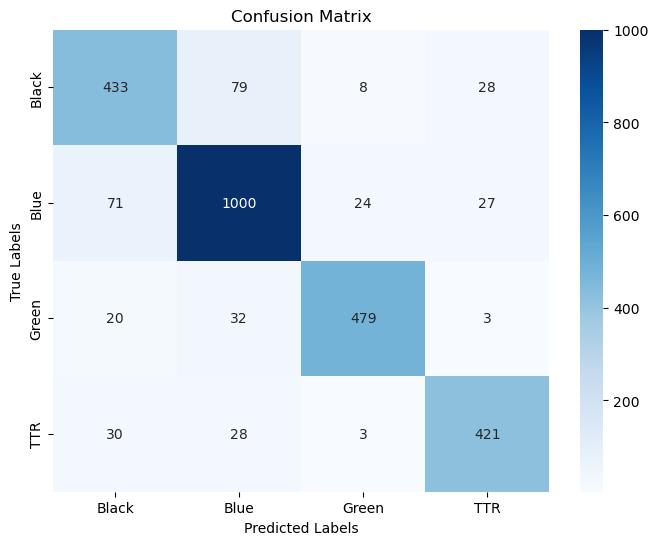


Fold 2:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3671, Test Accuracy: 0.8686

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.77      0.79       548
        Blue       0.87      0.90      0.89      1122
       Green       0.91      0.91      0.91       534
         TTR       0.89      0.86      0.87       482

    accuracy                           0.87      2686
   macro avg       0.87      0.86      0.86      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8638
Micro F1: 0.8686
Weighted F1: 0.8682
Per-class F1: Black: 0.7852, Blue: 0.8869, Green: 0.9089, TTR: 0.8741
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_gated_only_fold_2.png


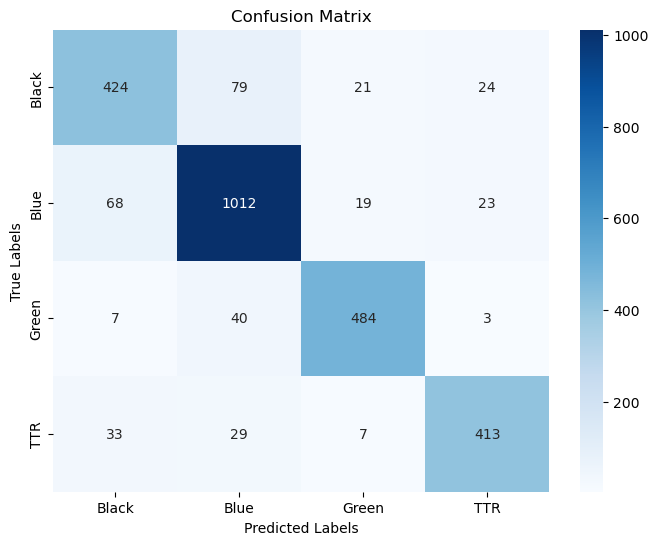


Fold 3:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3835, Test Accuracy: 0.8600

Classification Report:
               precision    recall  f1-score   support

       Black       0.74      0.81      0.78       548
        Blue       0.89      0.87      0.88      1122
       Green       0.91      0.90      0.91       534
         TTR       0.88      0.86      0.87       482

    accuracy                           0.86      2686
   macro avg       0.86      0.86      0.86      2686
weighted avg       0.86      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8570
Micro F1: 0.8600
Weighted F1: 0.8609
Per-class F1: Black: 0.7762, Blue: 0.8779, Green: 0.9060, TTR: 0.8676
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_gated_only_fold_3.png


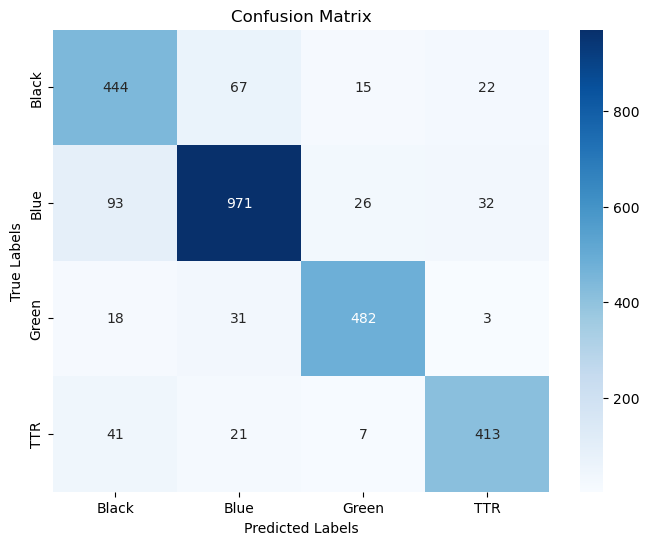


Fold 4:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3535, Test Accuracy: 0.8771

Classification Report:
               precision    recall  f1-score   support

       Black       0.84      0.76      0.80       548
        Blue       0.88      0.90      0.89      1122
       Green       0.90      0.94      0.92       534
         TTR       0.88      0.90      0.89       482

    accuracy                           0.88      2686
   macro avg       0.87      0.87      0.87      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8733
Micro F1: 0.8771
Weighted F1: 0.8761
Per-class F1: Black: 0.7985, Blue: 0.8890, Green: 0.9179, TTR: 0.8880
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_gated_only_fold_4.png


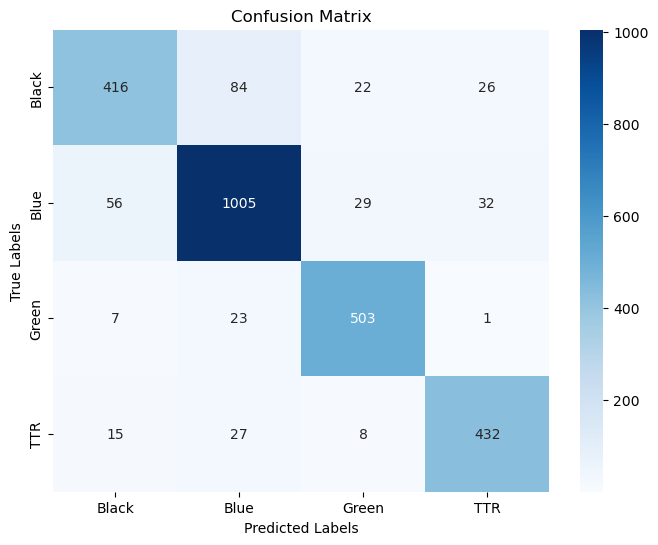


Fold 5:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3742, Test Accuracy: 0.8663

Classification Report:
               precision    recall  f1-score   support

       Black       0.73      0.86      0.79       548
        Blue       0.89      0.88      0.88      1122
       Green       0.92      0.90      0.91       534
         TTR       0.94      0.81      0.87       482

    accuracy                           0.87      2686
   macro avg       0.87      0.86      0.86      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8638
Micro F1: 0.8663
Weighted F1: 0.8679
Per-class F1: Black: 0.7889, Blue: 0.8848, Green: 0.9108, TTR: 0.8708
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_gated_only_fold_5.png


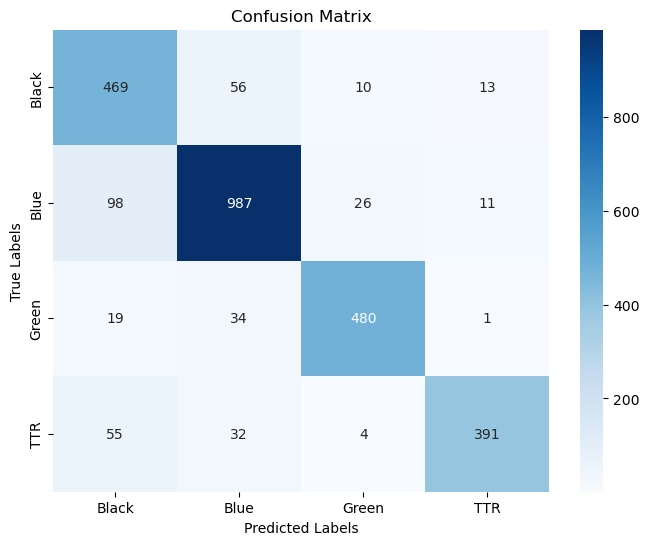


Saved individual fold results to model_results/Gated_Only_fold_results.csv

Evaluating Simple Concat model across all folds

Fold 1:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3328, Test Accuracy: 0.8764

Classification Report:
               precision    recall  f1-score   support

       Black       0.84      0.76      0.80       548
        Blue       0.86      0.92      0.89      1122
       Green       0.94      0.91      0.93       534
         TTR       0.88      0.87      0.88       482

    accuracy                           0.88      2686
   macro avg       0.88      0.87      0.87      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8726
Micro F1: 0.8764
Weighted F1: 0.8757
Per-class F1: Black: 0.7966, Blue: 0.8891, Green: 0.9266, TTR: 0.8780
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_enetb0_224_simple_concat_fold_1.png


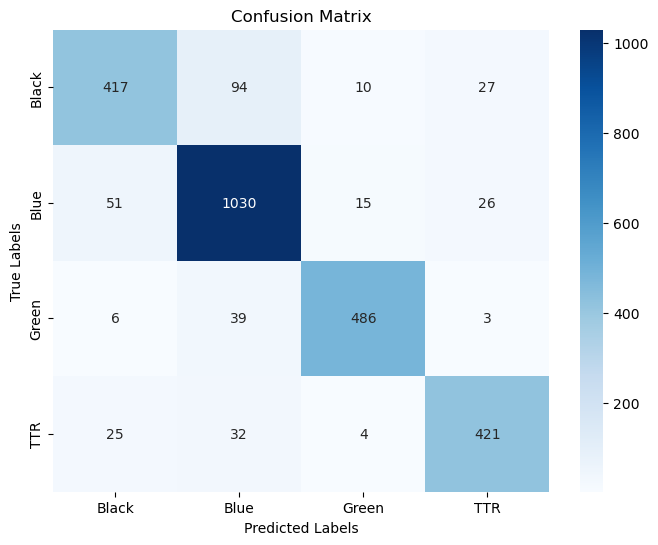


Fold 2:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3281, Test Accuracy: 0.8853

Classification Report:
               precision    recall  f1-score   support

       Black       0.83      0.79      0.81       548
        Blue       0.88      0.92      0.90      1122
       Green       0.93      0.92      0.93       534
         TTR       0.92      0.88      0.90       482

    accuracy                           0.89      2686
   macro avg       0.89      0.88      0.88      2686
weighted avg       0.89      0.89      0.88      2686


F1 Scores:
Macro F1: 0.8827
Micro F1: 0.8853
Weighted F1: 0.8850
Per-class F1: Black: 0.8097, Blue: 0.8963, Green: 0.9257, TTR: 0.8993
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_enetb0_224_simple_concat_fold_2.png


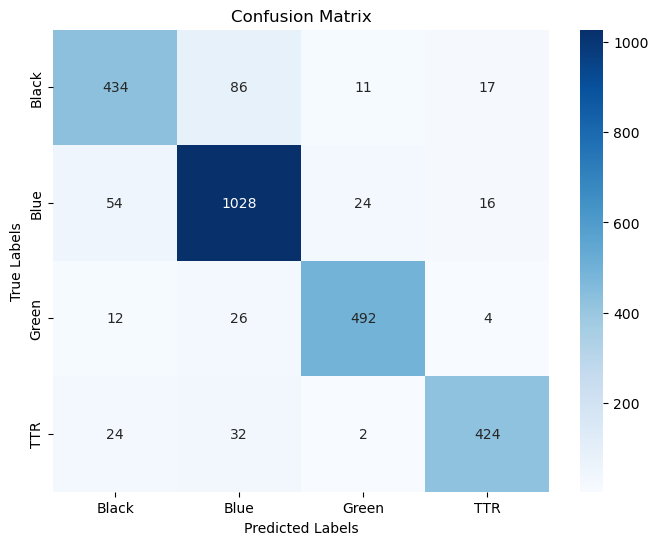


Fold 3:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3455, Test Accuracy: 0.8753

Classification Report:
               precision    recall  f1-score   support

       Black       0.79      0.81      0.80       548
        Blue       0.90      0.87      0.89      1122
       Green       0.90      0.92      0.91       534
         TTR       0.88      0.90      0.89       482

    accuracy                           0.88      2686
   macro avg       0.87      0.88      0.87      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8726
Micro F1: 0.8753
Weighted F1: 0.8754
Per-class F1: Black: 0.7996, Blue: 0.8886, Green: 0.9138, TTR: 0.8884
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_enetb0_224_simple_concat_fold_3.png


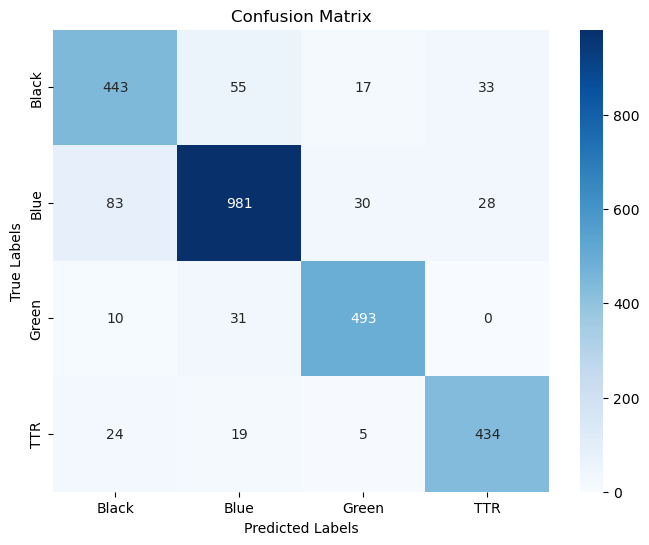


Fold 4:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3543, Test Accuracy: 0.8786

Classification Report:
               precision    recall  f1-score   support

       Black       0.84      0.77      0.81       548
        Blue       0.88      0.90      0.89      1122
       Green       0.88      0.93      0.91       534
         TTR       0.90      0.90      0.90       482

    accuracy                           0.88      2686
   macro avg       0.88      0.87      0.88      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8754
Micro F1: 0.8786
Weighted F1: 0.8778
Per-class F1: Black: 0.8065, Blue: 0.8901, Green: 0.9059, TTR: 0.8993
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_enetb0_224_simple_concat_fold_4.png


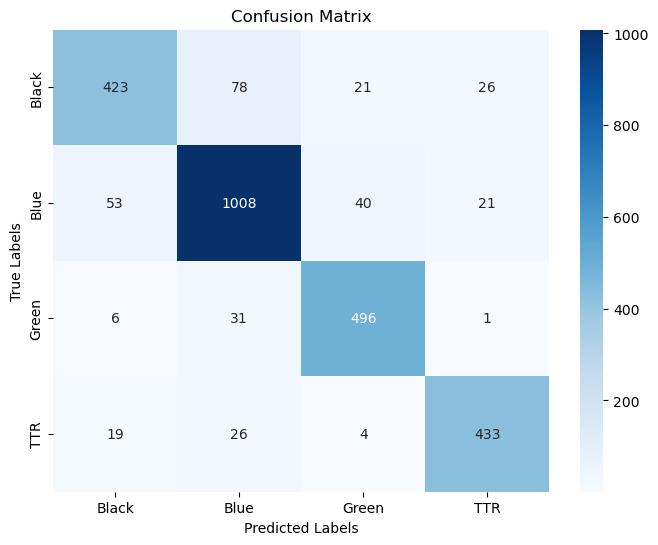


Fold 5:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3576, Test Accuracy: 0.8850

Classification Report:
               precision    recall  f1-score   support

       Black       0.82      0.81      0.81       548
        Blue       0.90      0.89      0.89      1122
       Green       0.92      0.93      0.92       534
         TTR       0.90      0.91      0.90       482

    accuracy                           0.88      2686
   macro avg       0.88      0.88      0.88      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8833
Micro F1: 0.8850
Weighted F1: 0.8849
Per-class F1: Black: 0.8143, Blue: 0.8939, Green: 0.9229, TTR: 0.9020
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_enetb0_224_simple_concat_fold_5.png


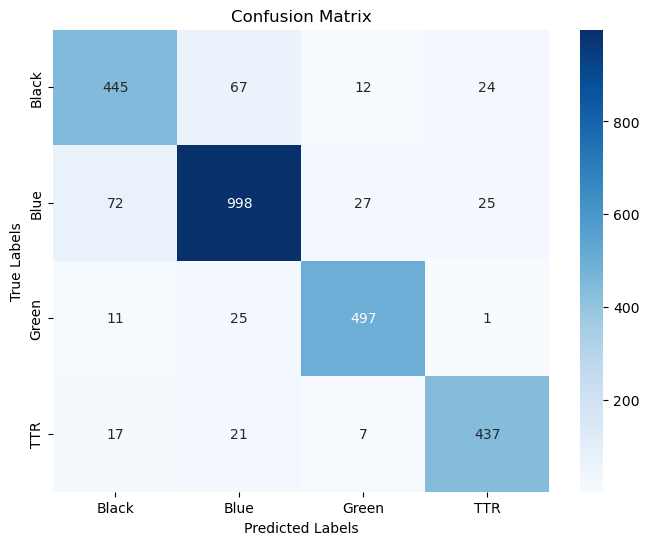


Saved individual fold results to model_results/Simple_Concat_fold_results.csv

Evaluating Transformer Fusion model across all folds

Fold 1:


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se


Test Loss: 0.3909, Test Accuracy: 0.8619

Classification Report:
               precision    recall  f1-score   support

       Black       0.75      0.82      0.78       548
        Blue       0.91      0.84      0.88      1122
       Green       0.86      0.93      0.89       534
         TTR       0.91      0.88      0.89       482

    accuracy                           0.86      2686
   macro avg       0.86      0.87      0.86      2686
weighted avg       0.87      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8605
Micro F1: 0.8619
Weighted F1: 0.8627
Per-class F1: Black: 0.7815, Blue: 0.8751, Green: 0.8931, TTR: 0.8924
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_transformer_fusion_fold_1.png


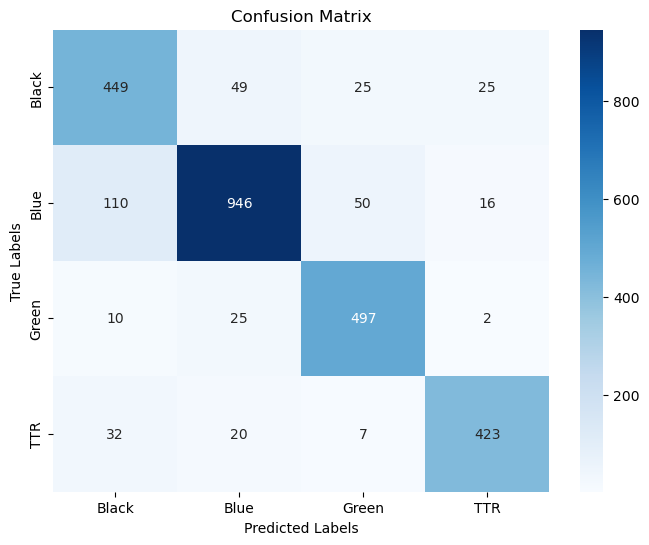


Fold 2:


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se


Test Loss: 0.3894, Test Accuracy: 0.8608

Classification Report:
               precision    recall  f1-score   support

       Black       0.78      0.77      0.78       548
        Blue       0.90      0.87      0.88      1122
       Green       0.87      0.94      0.90       534
         TTR       0.87      0.85      0.86       482

    accuracy                           0.86      2686
   macro avg       0.85      0.86      0.85      2686
weighted avg       0.86      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8549
Micro F1: 0.8608
Weighted F1: 0.8605
Per-class F1: Black: 0.7766, Blue: 0.8829, Green: 0.9001, TTR: 0.8601
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_transformer_fusion_fold_2.png


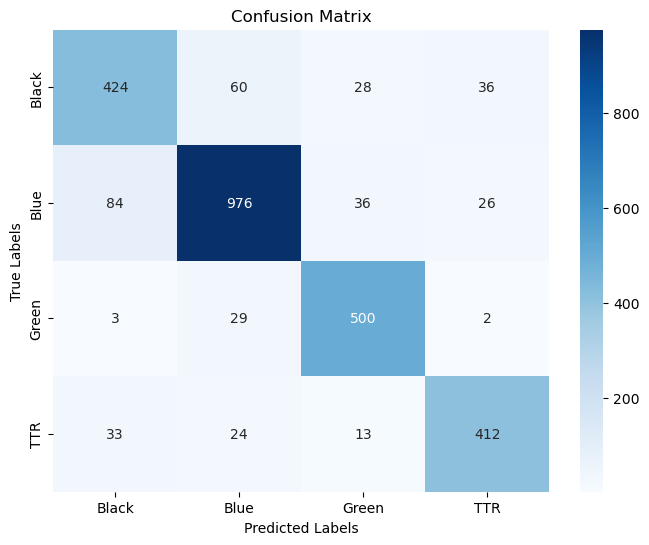


Fold 3:


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se


Test Loss: 0.3736, Test Accuracy: 0.8649

Classification Report:
               precision    recall  f1-score   support

       Black       0.76      0.77      0.77       548
        Blue       0.87      0.89      0.88      1122
       Green       0.93      0.90      0.91       534
         TTR       0.90      0.87      0.88       482

    accuracy                           0.86      2686
   macro avg       0.86      0.86      0.86      2686
weighted avg       0.87      0.86      0.87      2686


F1 Scores:
Macro F1: 0.8615
Micro F1: 0.8649
Weighted F1: 0.8651
Per-class F1: Black: 0.7663, Blue: 0.8825, Green: 0.9125, TTR: 0.8845
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_transformer_fusion_fold_3.png


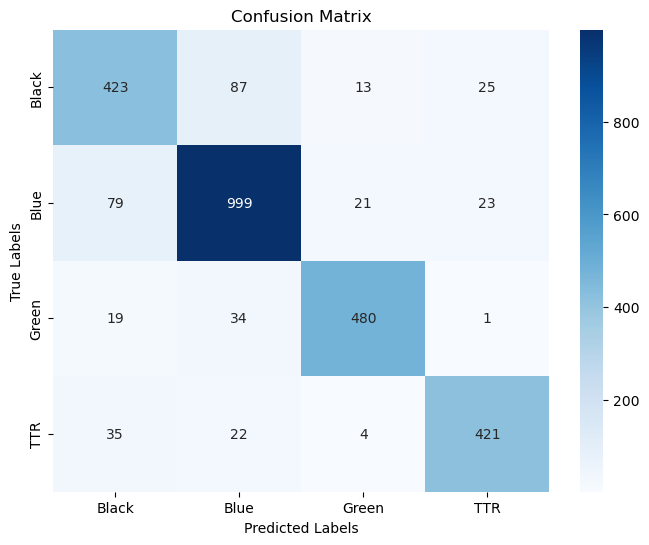


Fold 4:


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se


Test Loss: 0.3817, Test Accuracy: 0.8611

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.74      0.77       548
        Blue       0.87      0.89      0.88      1122
       Green       0.92      0.89      0.90       534
         TTR       0.86      0.89      0.87       482

    accuracy                           0.86      2686
   macro avg       0.86      0.85      0.86      2686
weighted avg       0.86      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8558
Micro F1: 0.8611
Weighted F1: 0.8604
Per-class F1: Black: 0.7652, Blue: 0.8803, Green: 0.9041, TTR: 0.8737
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_transformer_fusion_fold_4.png


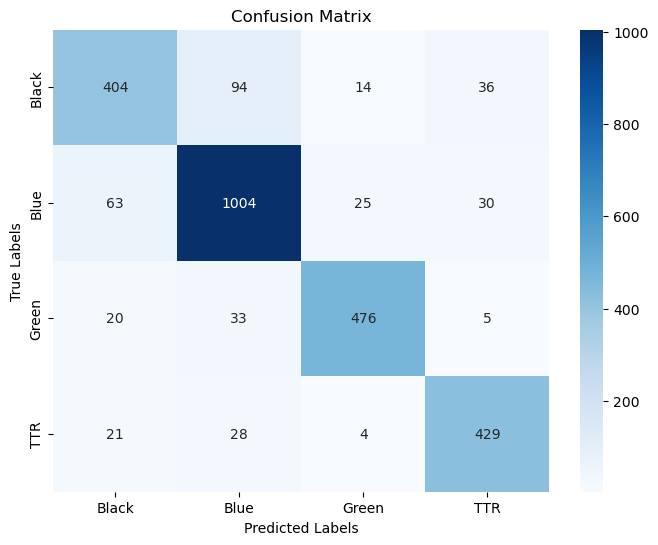


Fold 5:


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se


Test Loss: 0.3764, Test Accuracy: 0.8727

Classification Report:
               precision    recall  f1-score   support

       Black       0.77      0.79      0.78       548
        Blue       0.88      0.90      0.89      1122
       Green       0.93      0.92      0.92       534
         TTR       0.92      0.85      0.88       482

    accuracy                           0.87      2686
   macro avg       0.87      0.87      0.87      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8696
Micro F1: 0.8727
Weighted F1: 0.8730
Per-class F1: Black: 0.7824, Blue: 0.8884, Green: 0.9247, TTR: 0.8829
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_transformer_fusion_fold_5.png


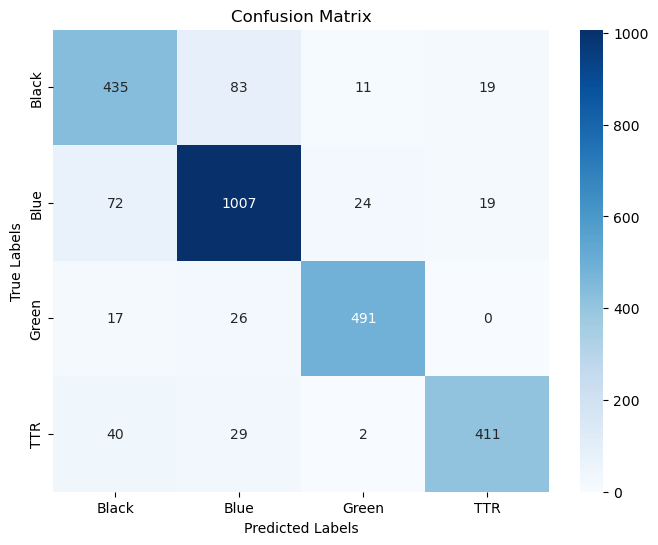


Saved individual fold results to model_results/Transformer_Fusion_fold_results.csv

Evaluating Gated Attention model across all folds

Fold 1:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3706, Test Accuracy: 0.8615

Classification Report:
               precision    recall  f1-score   support

       Black       0.83      0.71      0.76       548
        Blue       0.87      0.90      0.89      1122
       Green       0.88      0.92      0.90       534
         TTR       0.84      0.89      0.86       482

    accuracy                           0.86      2686
   macro avg       0.86      0.85      0.85      2686
weighted avg       0.86      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8527
Micro F1: 0.8615
Weighted F1: 0.8597
Per-class F1: Black: 0.7626, Blue: 0.8876, Green: 0.8997, TTR: 0.8609
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_gated_fusion_fold_1.png


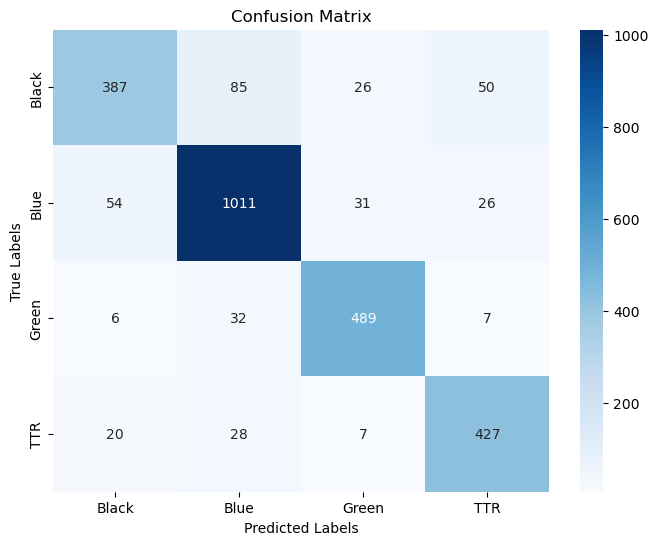


Fold 2:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3547, Test Accuracy: 0.8768

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.81      0.81       548
        Blue       0.89      0.89      0.89      1122
       Green       0.90      0.93      0.92       534
         TTR       0.90      0.86      0.88       482

    accuracy                           0.88      2686
   macro avg       0.87      0.87      0.87      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8734
Micro F1: 0.8768
Weighted F1: 0.8767
Per-class F1: Black: 0.8065, Blue: 0.8906, Green: 0.9170, TTR: 0.8797
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_gated_fusion_fold_2.png


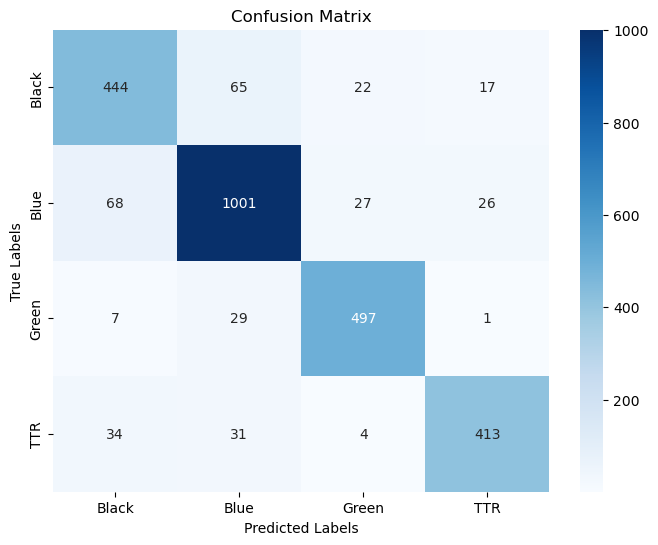


Fold 3:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3657, Test Accuracy: 0.8757

Classification Report:
               precision    recall  f1-score   support

       Black       0.79      0.79      0.79       548
        Blue       0.88      0.90      0.89      1122
       Green       0.93      0.92      0.92       534
         TTR       0.89      0.87      0.88       482

    accuracy                           0.88      2686
   macro avg       0.87      0.87      0.87      2686
weighted avg       0.88      0.88      0.88      2686


F1 Scores:
Macro F1: 0.8722
Micro F1: 0.8757
Weighted F1: 0.8756
Per-class F1: Black: 0.7938, Blue: 0.8905, Green: 0.9248, TTR: 0.8797
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_gated_fusion_fold_3.png


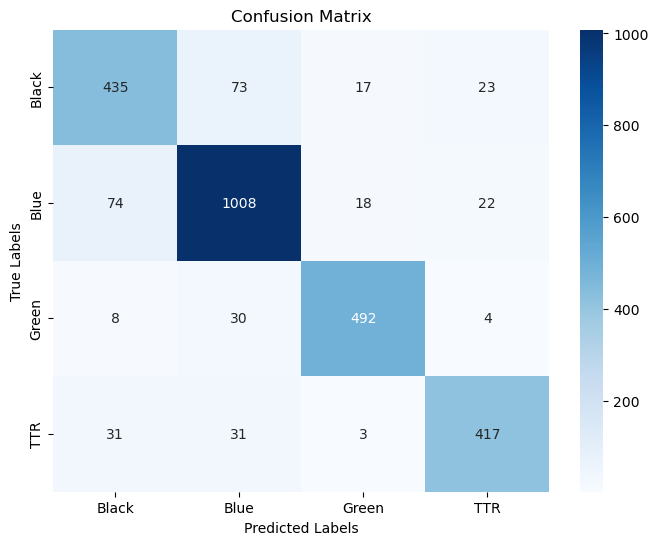


Fold 4:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3676, Test Accuracy: 0.8663

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.76      0.78       548
        Blue       0.86      0.91      0.88      1122
       Green       0.93      0.90      0.91       534
         TTR       0.89      0.87      0.88       482

    accuracy                           0.87      2686
   macro avg       0.87      0.86      0.86      2686
weighted avg       0.87      0.87      0.87      2686


F1 Scores:
Macro F1: 0.8622
Micro F1: 0.8663
Weighted F1: 0.8659
Per-class F1: Black: 0.7757, Blue: 0.8827, Green: 0.9133, TTR: 0.8770
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_gated_fusion_fold_4.png


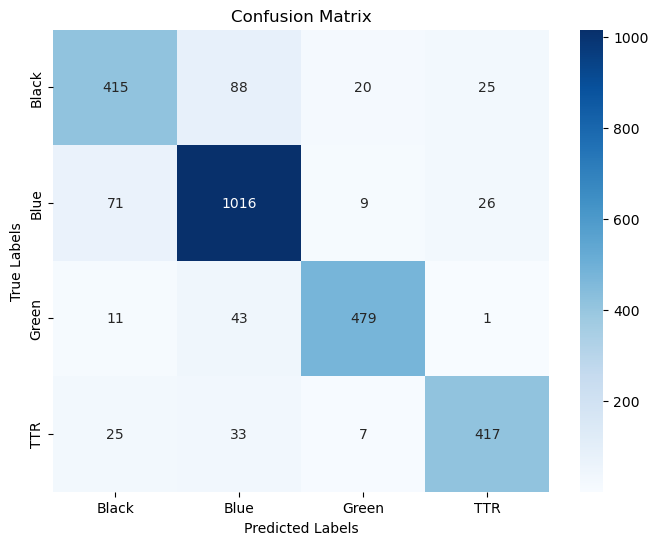


Fold 5:


C:\Users\arkzs\AppData\Local\Temp\ipykernel_33480\1287363290.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Test Loss: 0.3633, Test Accuracy: 0.8619

Classification Report:
               precision    recall  f1-score   support

       Black       0.81      0.71      0.76       548
        Blue       0.86      0.91      0.89      1122
       Green       0.88      0.92      0.90       534
         TTR       0.89      0.86      0.88       482

    accuracy                           0.86      2686
   macro avg       0.86      0.85      0.85      2686
weighted avg       0.86      0.86      0.86      2686


F1 Scores:
Macro F1: 0.8545
Micro F1: 0.8619
Weighted F1: 0.8603
Per-class F1: Black: 0.7578, Blue: 0.8851, Green: 0.8986, TTR: 0.8765
Saved confusion matrix to confusion_matrices\cm_experiment_multimodal_attention_gated_fusion_fold_5.png


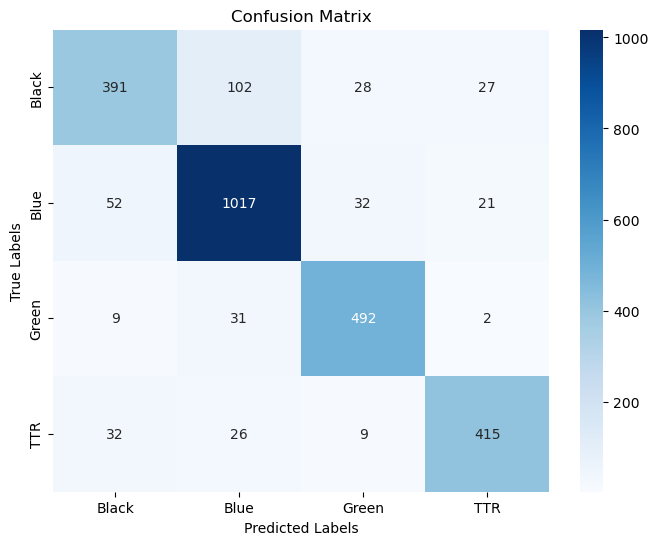


Saved individual fold results to model_results/Gated_Attention_fold_results.csv

COMPREHENSIVE MODEL COMPARISON (Mean ± Std Dev across 5 folds)
                           Accuracy        Precision           Recall  \
Attention Only      0.8722 ± 0.0072  0.8719 ± 0.0091  0.8666 ± 0.0071   
Gated Only          0.8681 ± 0.0055  0.8676 ± 0.0063  0.8632 ± 0.0052   
Simple Concat       0.8801 ± 0.0042  0.8796 ± 0.0065  0.8757 ± 0.0061   
Transformer Fusion  0.8643 ± 0.0044  0.8611 ± 0.0077  0.8609 ± 0.0052   
Gated Attention     0.8684 ± 0.0066  0.8671 ± 0.0076  0.8602 ± 0.0091   

                           F1-score          EvalTime         F1_Black  \
Attention Only      0.8690 ± 0.0077  73.3771 ± 1.6327  0.7887 ± 0.0126   
Gated Only          0.8646 ± 0.0052  72.9082 ± 1.2228  0.7869 ± 0.0072   
Simple Concat       0.8773 ± 0.0047  71.7557 ± 0.8398  0.8053 ± 0.0065   
Transformer Fusion  0.8605 ± 0.0052  71.3566 ± 0.2124  0.7744 ± 0.0074   
Gated Attention     0.8630 ± 0.0086  72.8012 ±

In [16]:
import pandas as pd
import numpy as np
from collections import defaultdict
import torch
import os
import time  # Added for timing measurements

# Create directories if they don't exist
os.makedirs("confusion_matrices", exist_ok=True)
os.makedirs("plots", exist_ok=True)
os.makedirs("model_results", exist_ok=True)

# Initialize dictionaries to store metrics
all_models_metrics = defaultdict(dict)
all_models_fold_results = defaultdict(list)

class_labels = ["Black", "Blue", "Green", "TTR"]
model_architectures = [
    ("Attention Only", "MultimodalClassifierAttentionOnly", "experiment_multimodal_attention_only_fold_{}.pth"),
    ("Gated Only", "MultimodalClassifierGatedOnly", "experiment_multimodal_gated_only_fold_{}.pth"),
    ("Simple Concat", "MultimodalClassifierEnet", "experiment_multimodal_enetb0_224_simple_concat_fold_{}.pth"),
    ("Transformer Fusion", "MultimodalClassifierTransformerFusion", "experiment_multimodal_transformer_fusion_fold_{}.pth"),
    ("Gated Attention", "MultimodalClassifierGatedAttention", "experiment_multimodal_attention_gated_fusion_fold_{}.pth")
]

for model_name, model_class, model_path_template in model_architectures:
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name} model across all folds")
    print(f"{'='*60}")
    
    fold_metrics = {
        'accuracies': [],
        'precisions': [],
        'recalls': [],
        'f1_scores': [],
        'per_class_f1': [],
        'eval_times': []  # Added for timing storage
    }

    model_fold_results = []
    
    for fold in range(1, 6):
        print(f"\nFold {fold}:")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        try:
            # Load model
            model_class_obj = globals()[model_class]
            model = model_class_obj(num_classes=NUM_CLASSES).to(device)
            model_path = model_path_template.format(fold)
            model.load_state_dict(torch.load(model_path))
            
            # Time the evaluation
            start_time = time.time()
            test_accuracy, test_report, test_roc_auc, test_pr_auc, f1_scores = test_model_with_metrics(
                model, test_loader, device, class_labels,
                show_confusion_matrix=True, 
                show_roc_curve=False, 
                show_pr_curve=False,
                model_path=model_path
            )
            eval_time = time.time() - start_time
            
            # Store metrics
            fold_metrics['accuracies'].append(test_accuracy)
            fold_metrics['precisions'].append(test_report['macro avg']['precision'])
            fold_metrics['recalls'].append(test_report['macro avg']['recall'])
            fold_metrics['f1_scores'].append(test_report['macro avg']['f1-score'])
            fold_metrics['per_class_f1'].append(f1_scores['per_class'])
            fold_metrics['eval_times'].append(eval_time)  # Store evaluation time
            
            # Record individual fold results
            fold_result = {
                'Fold': fold,
                'Accuracy': test_accuracy,
                'Precision': test_report['macro avg']['precision'],
                'Recall': test_report['macro avg']['recall'],
                'F1-score': test_report['macro avg']['f1-score'],
                'Eval_Time': eval_time,  # Added evaluation time
                **{f"F1_{class_name}": score for class_name, score in zip(class_labels, f1_scores['per_class'])}
            }
            model_fold_results.append(fold_result)
            
        except Exception as e:
            print(f"Error evaluating {model_name} fold {fold}: {str(e)}")
            continue

    # Save individual model results
    model_results_df = pd.DataFrame(model_fold_results)
    individual_csv_path = f"model_results/{model_name.replace(' ', '_')}_fold_results.csv"
    model_results_df.to_csv(individual_csv_path, index=False)
    print(f"\nSaved individual fold results to {individual_csv_path}")

    # Calculate statistics
    def calculate_stats(values):
        return np.mean(values), np.std(values)

    # Calculate averages and standard deviations
    avg_accuracy, std_accuracy = calculate_stats(fold_metrics['accuracies'])
    avg_precision, std_precision = calculate_stats(fold_metrics['precisions'])
    avg_recall, std_recall = calculate_stats(fold_metrics['recalls'])
    avg_f1, std_f1 = calculate_stats(fold_metrics['f1_scores'])
    avg_time, std_time = calculate_stats(fold_metrics['eval_times'])  # Timing stats
    avg_per_class_f1 = np.mean(fold_metrics['per_class_f1'], axis=0)
    std_per_class_f1 = np.std(fold_metrics['per_class_f1'], axis=0)

    # Store results for comprehensive comparison
    all_models_metrics[model_name] = {
        'Accuracy_Avg': avg_accuracy,
        'Accuracy_Std': std_accuracy,
        'Precision_Avg': avg_precision,
        'Precision_Std': std_precision,
        'Recall_Avg': avg_recall,
        'Recall_Std': std_recall,
        'F1-score_Avg': avg_f1,
        'F1-score_Std': std_f1,
        'EvalTime_Avg': avg_time,  # Added average evaluation time
        'EvalTime_Std': std_time,  # Added evaluation time std dev
        **{f"F1_{class_name}_Avg": avg for class_name, avg in zip(class_labels, avg_per_class_f1)},
        **{f"F1_{class_name}_Std": std for class_name, std in zip(class_labels, std_per_class_f1)}
    }

# Create comprehensive comparison DataFrame
metrics_df = pd.DataFrame.from_dict(all_models_metrics, orient='index')

# Reorder columns for better readability
main_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'EvalTime']  # Added EvalTime
columns_order = []
for metric in main_metrics:
    columns_order.extend([f"{metric}_Avg", f"{metric}_Std"])
columns_order.extend([f"F1_{cls}_Avg" for cls in class_labels])
columns_order.extend([f"F1_{cls}_Std" for cls in class_labels])

metrics_df = metrics_df[columns_order]

# Format the DataFrame for display
display_df = metrics_df.copy()
for col in display_df.columns:
    if '_Avg' in col:
        std_col = col.replace('_Avg', '_Std')
        display_df[col] = display_df.apply(
            lambda x: f"{x[col]:.4f} ± {x[std_col]:.4f}", axis=1
        )
        display_df.drop(std_col, axis=1, inplace=True)

# Rename columns for display
display_df.columns = [col.replace('_Avg', '') for col in display_df.columns]

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON (Mean ± Std Dev across 5 folds)")
print("="*80)
print(display_df)

# Save both versions
metrics_df.to_csv("model_comparison_results_detailed.csv")
display_df.to_csv("model_comparison_results.csv")
print("\nResults saved to:")
print("- model_comparison_results.csv (formatted)")
print("- model_comparison_results_detailed.csv (with separate Avg/Std columns)")

# Majority Voting

Using the best fold from each model architecture, we will combine their predictions into a majority vote using the below code and evaluate its performance.

Evaluating model_attention_gated:
Evaluating model_attention_only:
Evaluating model_gated_only:
Evaluating model_enetb0_224_simple_concat:
Evaluating model_transformer_fusion:


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Test Accuracy: 0.8912881608339538
Macro F1: 0.8889270939140677
Micro F1: 0.8912881608339538
Weighted F1: 0.8914109496595725
Per-class F1: {'Black': np.float64(0.8278985507246377), 'Blue': np.float64(0.9023746701846965), 'Green': np.float64(0.9291784702549575), 'TTR': np.float64(0.8962566844919786)}

Classification Report:
               precision    recall  f1-score   support

       Black   0.821942  0.833942  0.827899       548
        Blue   0.890625  0.914439  0.902375      1122
       Green   0.937143  0.921348  0.929178       534
         TTR   0.924945  0.869295  0.896257       482

    accuracy                       0.891288      2686
   macro avg   0.893664  0.884756  0.888927      2686
weighted avg   0.892019  0.891288  0.891411      2686



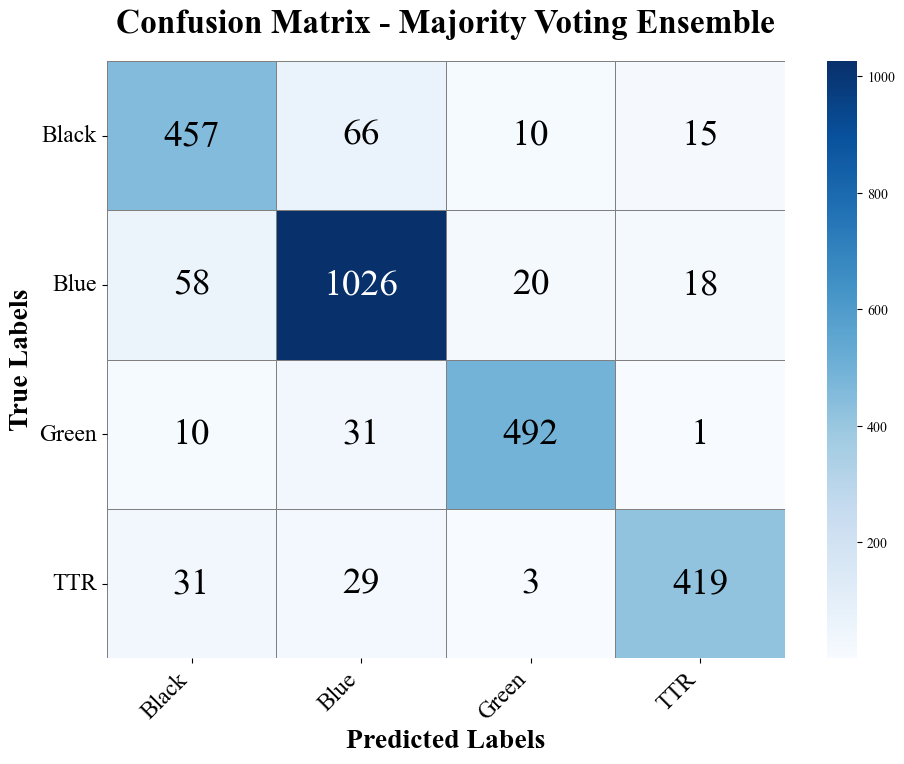

In [25]:
# Best folds of each model architecture are:
# Attention Only: 5
# Gated Only: 5
# Simple Concat: 2
# Transformer Fusion: 4
# Gated + Attention: 2

# ========================================= RUN TESTING OF BEST MODELS FOR EACH FUSION & METRICS ================================================

class_labels = ["Black", "Blue", "Green", "TTR"]
best_models = []

# Attention Gated
print("Evaluating model_attention_gated:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_attention_gated = MultimodalClassifierGatedAttention(num_classes=NUM_CLASSES).to(device)
model_attention_gated.load_state_dict(torch.load("experiment_multimodal_attention_gated_fusion_fold_2.pth", weights_only = True))
best_models.append(model_attention_gated)

# Attention Only
print("Evaluating model_attention_only:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_attention_only = MultimodalClassifierAttentionOnly(num_classes=NUM_CLASSES).to(device)
model_attention_only.load_state_dict(torch.load("experiment_multimodal_attention_only_fold_5.pth", weights_only = True))
best_models.append(model_attention_only)

# Gated Only
print("Evaluating model_gated_only:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gated_only = MultimodalClassifierGatedOnly(num_classes=NUM_CLASSES).to(device)
model_gated_only.load_state_dict(torch.load("experiment_multimodal_gated_only_fold_5.pth", weights_only = True))
best_models.append(model_gated_only)

# Simple Concat
print("Evaluating model_enetb0_224_simple_concat:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_enet = MultimodalClassifierEnet(num_classes=NUM_CLASSES).to(device)
model_enet.load_state_dict(torch.load("experiment_multimodal_enetb0_224_simple_concat_fold_2.pth", weights_only = True))
best_models.append(model_enet)

# Transformer Fusion
print("Evaluating model_transformer_fusion:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transformer = MultimodalClassifierTransformerFusion(num_classes=NUM_CLASSES).to(device)
model_transformer.load_state_dict(torch.load("experiment_multimodal_transformer_fusion_fold_4.pth", weights_only = True))
best_models.append(model_transformer)


all_model_preds = [] 

for model in best_models:
    model.eval()
    preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask, images)
            pred = torch.argmax(outputs, dim=1)
            preds.append(pred.cpu().numpy())
    
    preds = np.concatenate(preds)
    all_model_preds.append(preds)

# Perform Majority Voting

# Shape: [num_models, num_samples]
all_model_preds = np.array(all_model_preds)

# Majority vote across axis 0 (models)
majority_preds, _ = mode(all_model_preds, axis=0, keepdims=False)


# Evaluate Majority Vote Predictions
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

true_labels = test_labels

accuracy = accuracy_score(true_labels, majority_preds)
f1_macro = f1_score(true_labels, majority_preds, average='macro')
f1_micro = f1_score(true_labels, majority_preds, average='micro')
f1_weighted = f1_score(true_labels, majority_preds, average='weighted')
f1_per_class = f1_score(true_labels, majority_preds, average=None)

conf_matrix = confusion_matrix(true_labels, majority_preds)
class_report = classification_report(true_labels, majority_preds, target_names=CLASSES, digits=6)

# Print results
print("Test Accuracy:", accuracy)
print("Macro F1:", f1_macro)
print("Micro F1:", f1_micro)
print("Weighted F1:", f1_weighted)
print("Per-class F1:", dict(zip(CLASSES, f1_per_class)))
print("\nClassification Report:\n", class_report)

plt.close('all')

# Set Times New Roman font for all text
plt.rcParams['font.family'] = 'Times New Roman'

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                cbar=True,
                annot_kws={
                    "size": 14,
                    "fontfamily": "Times New Roman",
                    "ha": "center",  # Explicit horizontal alignment
                    "va": "center"   # Explicit vertical alignment
                },
                linewidths=0.5, 
                linecolor='gray')

# Customize the plot with Times New Roman
plt.xlabel("Predicted Labels", 
          fontsize=20, 
          fontweight='bold',
          fontfamily="Times New Roman")
plt.ylabel("True Labels", 
          fontsize=20, 
          fontweight='bold',
          fontfamily="Times New Roman")
plt.title("Confusion Matrix - Majority Voting Ensemble", 
         fontsize=24, 
         pad=20, 
         fontweight='bold',
         fontfamily="Times New Roman")

# Adjust tick labels with proper alignment
ax.set_xticklabels(class_labels, 
                  fontsize=17, 
                  rotation=45, 
                  ha='right',
                  fontfamily="Times New Roman")
ax.set_yticklabels(class_labels, 
                  fontsize=17, 
                  rotation=0,
                  fontfamily="Times New Roman")

# Remove duplicate annotations (fix for overlay artifacts)
for text in ax.texts:
    text.remove()  # Clear auto-generated annotations

# Add custom annotations with perfect alignment
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j + 0.5,  # Center of cell
               i + 0.5, 
               str(conf_matrix[i, j]), 
               ha="center", 
               va="center", 
               color="black" if conf_matrix[i, j] < conf_matrix.max()/2 else "white",
               fontsize=27,
               fontfamily="Times New Roman")

# Adjust layout
plt.tight_layout(pad=2.0)
plt.show()



# Misclassified Samples

Below are some misclassified samples from the majority vote above. This aims to provide insight on mistakes that our model makes.


Showing 8 Misclassified Samples:


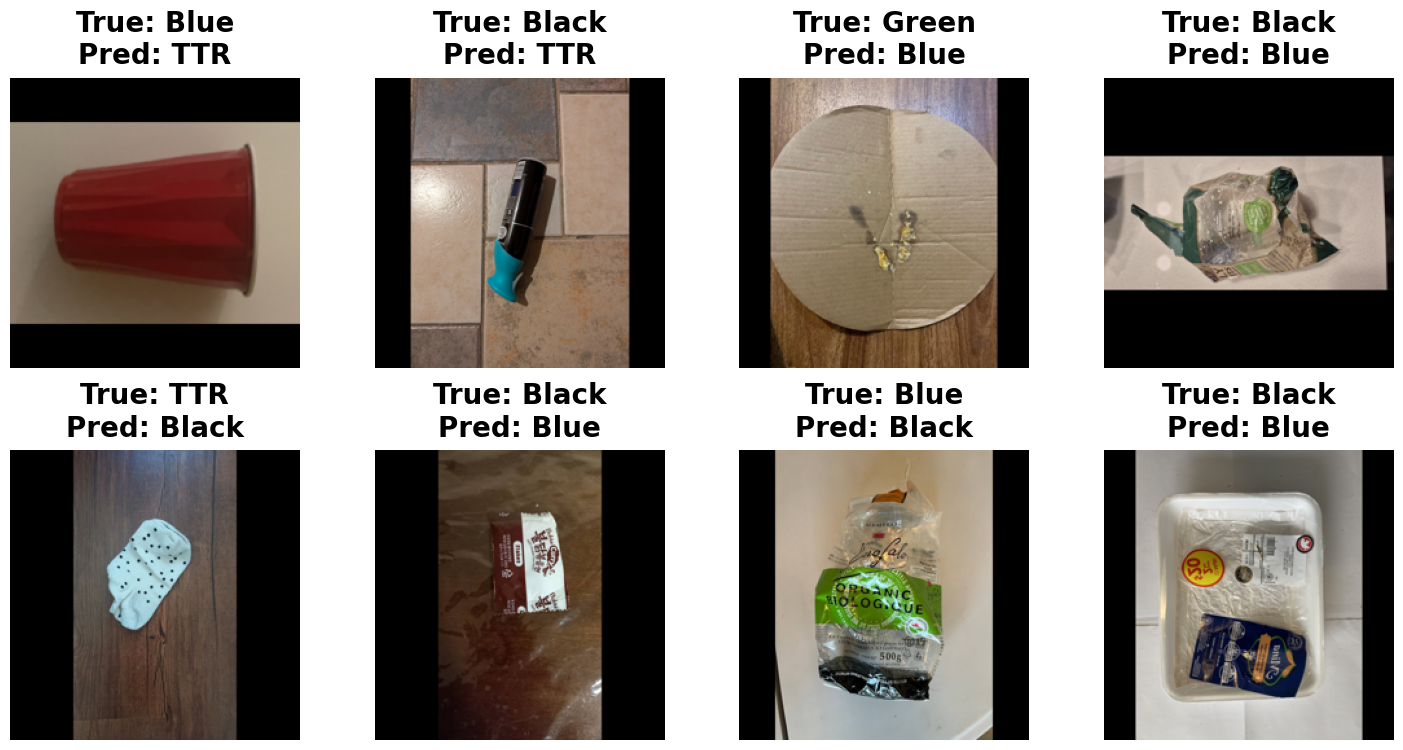

In [21]:
# --- Collect Misclassified Samples ---
misclassified = []
for i in range(len(true_labels)):
    if majority_preds[i] != true_labels[i]:
        misclassified.append({
            "index": i,
            "image_path": test_image_paths[i],
            "true_label": true_labels[i],
            "pred_label": majority_preds[i]
        })

# --- Display Misclassified Samples ---
def show_misclassified_images(misclassified, class_labels, max_display=6):
    if not misclassified:
        print("No misclassified samples to show.")
        return

    plt.figure(figsize=(15, 8))  # Slightly larger figure for better spacing
    for i, sample in enumerate(misclassified[:max_display]):
        image = Image.open(sample["image_path"]).convert("RGB")
        image = image.resize((224, 224))  # Match input size

        plt.subplot(2, (max_display + 1) // 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        
        # Enhanced title with larger font and better formatting
        title_text = f"True: {class_labels[sample['true_label']]}\nPred: {class_labels[sample['pred_label']]}"
        plt.title(title_text, 
                 fontsize=20,  # Increased from default
                 fontweight='bold', 
                 pad=10)  # Add padding between image and title
    
    plt.tight_layout(pad=3.0)  # Add more padding between subplots
    plt.show()

print(f"\nShowing {min(8, len(misclassified))} Misclassified Samples:")
show_misclassified_images(misclassified, class_labels=CLASSES, max_display=8)